In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import nltk
from nltk.corpus import stopwords
stopwords = stopwords.words('english')

In [3]:
rev = pd.read_csv('yelp.csv')
rev.head(3)

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I als...,review,0hT2KtfLiobPvh6cDC8JQg,0,1,0


In [4]:
date = pd.DatetimeIndex(rev['date'])
rev['year'] =  date.year
rev['month'] = date.month
rev['day'] = date.strftime('%a')

In [5]:
rev.head(2)

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny,year,month,day
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0,2011,1,Wed
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0,2011,7,Wed


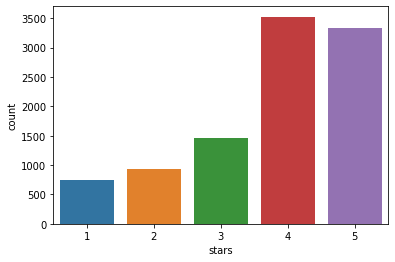

In [6]:
sns.countplot(rev['stars'])

In [7]:
reviews = rev[['business_id','user_id', 'date','text','year','month','day','stars']]
c1 = reviews['stars'] == 5              #ratings to be predicted
c2 = reviews['stars'] == 2
reviews = reviews[c1|c2]

In [8]:
reviews.head(2)

,business_id,user_id,date,text,year,month,day,stars
0,9yKzy9PApeiPPOUJEtnvkg,rLtl8ZkDX5vH5nAx9C3q5Q,2011-01-26,My wife took me here on my birthday for breakf...,2011,1,Wed,5
1,ZRJwVLyzEJq1VAihDhYiow,0a2KyEL0d3Yb1V6aivbIuQ,2011-07-27,I have no idea why some people give bad review...,2011,7,Wed,5


In [9]:
from sklearn.model_selection import train_test_split                  #split the data 'reviews' into train & test
train, test= train_test_split(reviews, test_size=0.25, random_state=42)

In [10]:
train = train.sort_values('date')    #got the target class and text
y_train = train['stars']
X_train = train['text']

y_test = test['stars']
X_test = test['text']

In [11]:
sub_X_train = train[['business_id', 'user_id', 'day']]  #put the other categorical columns in another dataframe
                                                        #for target encoding
sub_X_test  = test[['business_id', 'user_id', 'day']]


In [12]:
import category_encoders as ce                             
def cat_trans(a,b,c):                                   #function for target encoding
    cat_feat = ['business_id', 'user_id', 'day']
    t_encoder = ce.TargetEncoder(cols = cat_feat)
    t_encoder.fit(a, c)
    sub_X_train = t_encoder.transform(a)
    sub_X_test = t_encoder.transform(b)
    return (sub_X_train, sub_X_test)

In [13]:
a = cat_trans(sub_X_train, sub_X_test, y_train)   #retrieving the results of the function

In [14]:
import nltk
nltk.download('punkt')

[nltk_data] Error loading punkt: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


False

In [15]:
import nltk
nltk.download('wordnet')

[nltk_data] Error loading wordnet: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


False

In [16]:
import string

In [17]:
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import wordnet

In [18]:
stemmer = PorterStemmer()
lema = WordNetLemmatizer()

In [19]:
import re

In [20]:
def clean_a_text(text):                               #function for cleaning the text
    split_sentence = nltk.word_tokenize(text)
    no_punc = [char.lower() for char in split_sentence if char not in string.punctuation]
    sw_removed = [word for word in no_punc if word not in stopwords]
    lemmatized = [lema.lemmatize(word, pos = wordnet.VERB) for word in sw_removed]
    pattern = "[^~''`/*0-9... :]+"
    patt = '[a-zA-Z][a-zA-Z]+'
    final = re.findall(pattern, ' '.join(lemmatized))
    final2 = re.findall(patt, ' '.join(final))
    return final2

In [21]:
from wordcloud import WordCloud
                                                    #function for plotting word cloud of all words in the text
def plot_word_cloud(text):
    wordcloud_instance = WordCloud(width = 1500, height = 900, 
                background_color ='black', 
                stopwords=None,
                min_font_size = 10).generate(text)
    
    plt.figure(figsize = (10, 8), facecolor = None) 
    plt.imshow(wordcloud_instance) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.show()

In [22]:
words = ''                                             #combine all cleaned words from text into a string
for index, row in reviews[['text']].iterrows():
    for each in ' '.join(clean_a_text(row['text'])):
        words = words + each

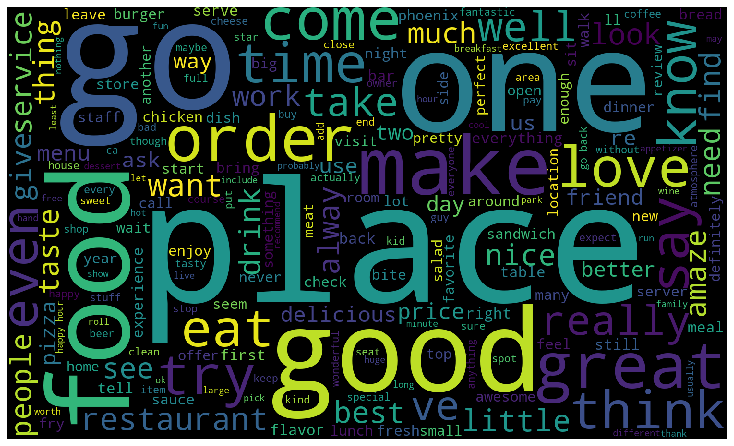

In [23]:
plot_word_cloud(words)

In [24]:
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

In [25]:
words_vector = CountVectorizer(analyzer= clean_a_text)

In [26]:
words_vector.fit(train['text'])

CountVectorizer(analyzer=<function clean_a_text at 0x00000243E7A45F28>,
                binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [27]:
X_train_values = words_vector.transform(train['text'])
X_test_values = words_vector.transform(test['text'])

In [28]:
X_train_values.shape, X_test_values.shape

((3198, 13883), (1066, 13883))

In [29]:
tfidf = TfidfTransformer()

In [30]:
X_train_values = tfidf.fit_transform(X_train_values)
X_test_values = tfidf.fit_transform(X_test_values)

In [31]:
features = words_vector.get_feature_names()   #got each word derived from the CountVectorizer analyzer as features

In [32]:
len(features)

13883

In [33]:
X_train_after_tfidf = pd.DataFrame(X_train_values.toarray(), columns= features, index= train.index) #dataframe of values after
                                                                                                    #countvectorizer and tfidf
X_text_after_tfidf = pd.DataFrame(X_test_values.toarray(), columns= features, index= test.index)

In [34]:
train_y_m = train[['year', 'month']]     #numeric dataframe to be concatenated with tfidf and target encoded dataframe
test_y_m = test[['year', 'month']]

In [35]:
X_train = pd.concat([a[0], train_y_m , X_train_after_tfidf], axis = 1)  #final dataframe

X_test = pd.concat([a[1], test_y_m , X_text_after_tfidf], axis = 1)

In [36]:
#X_train.head(2)

In [37]:
#X_test.head(2)

In [38]:
from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import MultinomialNB
from imblearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, confusion_matrix

In [39]:
my_pipeline = make_pipeline(SMOTE(),     
                        MultinomialNB())

In [40]:
my_pipeline.fit(X_train.values, y_train.values)

Pipeline(memory=None,
         steps=[('smote',
                 SMOTE(k_neighbors=5, n_jobs=None, random_state=None,
                       sampling_strategy='auto')),
                ('multinomialnb',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [41]:
pred = my_pipeline.predict(X_test)

In [42]:
print(classification_report(y_test, pred))
print(confusion_matrix(y_test, pred))

              precision    recall  f1-score   support

           2       0.77      0.83      0.80       224
           5       0.95      0.93      0.94       842

    accuracy                           0.91      1066
   macro avg       0.86      0.88      0.87      1066
weighted avg       0.92      0.91      0.91      1066

[[186  38]
 [ 55 787]]
